## Summary of the Full Preprocessing Pipeline
1. Face alignment using dlib landmarks (eyes horizontal). Fallback crop if no face detected. @Marcelino
2. CLAHE (adaptive histogram equalization) for contrast enhancement. @Marcelino
3. Random brightness & contrast augmentation. @Xinyi Zhu
4. Resize to 224x224. @Xinyi Zhu
5. Convert grayscale → 3 channels. @Deepak
6. Geometric augmentation: flip & rotation. @Deepak
7. Normalize with ImageNet stats.

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import cv2
import os
# import dlib
import numpy as np
import random

class FER2013ImageDataset(Dataset):
    def __init__(self, root_dir, img_size=224, augment=False):
        self.img_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.img_paths.append(os.path.join(cls_dir, fname))
                    self.labels.append(self.class_to_idx[cls_name])
        
        self.img_size = img_size
        self.augment = augment
        
        # ImageNet normalization
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        # Standard geometric augmentation
        self.aug_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
        ])
        
        # # Dlib detector and predictor
        # self.detector = dlib.get_frontal_face_detector()
        # self.predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    
    def align_face(self, img):
        faces = self.detector(img)
        if len(faces) > 0:
            face = faces[0]
            landmarks = self.predictor(img, face)
            
            left_eye = np.array([landmarks.part(36).x, landmarks.part(36).y])
            right_eye = np.array([landmarks.part(45).x, landmarks.part(45).y])
            eye_center = (left_eye + right_eye) / 2
            dy = right_eye[1] - left_eye[1]
            dx = right_eye[0] - left_eye[0]
            angle = np.degrees(np.arctan2(dy, dx))
            M = cv2.getRotationMatrix2D(tuple(eye_center), angle, 1.0)
            aligned = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
            
            # Crop to face bounding box
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            x, y = max(0, x), max(0, y)
            cropped = aligned[y:y+h, x:x+w]
            return cropped
        else:
            # Fallback: center crop
            h, w = img.shape
            min_dim = min(h, w)
            start_x = (w - min_dim) // 2
            start_y = (h - min_dim) // 2
            cropped = img[start_y:start_y+min_dim, start_x:start_x+min_dim]
            return cropped
    
    def clahe_equalize(self, img):
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        return clahe.apply(img)
    
    def random_brightness_contrast(self, img):
        # Convert to float32
        img = img.astype(np.float32) / 255.0
        # Random brightness: ±0.2
        brightness = random.uniform(-0.2, 0.2)
        img += brightness
        # Random contrast: ±0.2
        contrast = random.uniform(0.8, 1.2)
        img = (img - 0.5) * contrast + 0.5
        # Clip to [0,1] and convert back to uint8
        img = np.clip(img, 0, 1)
        img = (img * 255).astype(np.uint8)
        return img
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        path = self.img_paths[idx]
        label = self.labels[idx]
        
        # Read grayscale
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        # Face alignment or fallback crop
        img = self.align_face(img)
        
        # CLAHE
        img = self.clahe_equalize(img)
        
        # Random brightness and contrast
        if self.augment:
            img = self.random_brightness_contrast(img)
        
        # Resize
        img = cv2.resize(img, (self.img_size, self.img_size))
        
        # Convert to 3 channels
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        # To tensor
        img = transforms.ToTensor()(img)
        
        # Geometric augmentation
        if self.augment:
            img = self.aug_transform(img)
        
        # Normalize
        img = self.normalize(img)
        
        return img, torch.tensor(label, dtype=torch.long)

In [2]:
from torch.utils.data import DataLoader

train_dataset = FER2013ImageDataset('../../fer2013/train', augment=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = FER2013ImageDataset('../../fer2013/train', augment=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Comparison

### Transformation explanations

- Face alignment: Detects facial landmarks (eyes) and rotates the image so the eyes are horizontal. If no face is detected, a center crop is used as a fallback. This reduces pose variation and centers the face for downstream processing.

- CLAHE (Contrast Limited Adaptive Histogram Equalization): Enhances local contrast by applying histogram equalization on small tiles of the image with contrast limiting to avoid noise amplification. Good for improving details in low-contrast regions.

- Random brightness & contrast: Adds a small random brightness offset (±0.2) and scales contrast randomly (0.8–1.2). This augmentation makes the model robust to different lighting conditions.

- Resize: Resizes the image to the model input size (default 224×224). Ensures consistent spatial dimensions for batching and pre-trained backbones.

- Convert grayscale → 3 channels: Replicates the single grayscale channel across three channels so pre-trained RGB networks can be used.

- Geometric augmentation (flip & rotation): Random horizontal flips and small rotations (±10°) to add invariance to mirroring and slight head rotations.

- Normalize with ImageNet stats: Subtracts ImageNet mean and divides by ImageNet std for each channel so inputs match the scale expected by models pre-trained on ImageNet.

What the two comparison tables show:

- Table A — Original vs Brightness/Contrast: Each row shows the original grayscale image (left column) and the same image after applying the random brightness & contrast augmentation (right column). This helps visualize the appearance changes caused by lighting augmentation.

- Table B — Original vs Resized: Each row shows the original grayscale image (left column) and the image after resizing to the model input size (right column). This helps inspect how much detail is preserved or lost and whether cropping/resizing artifacts appear.

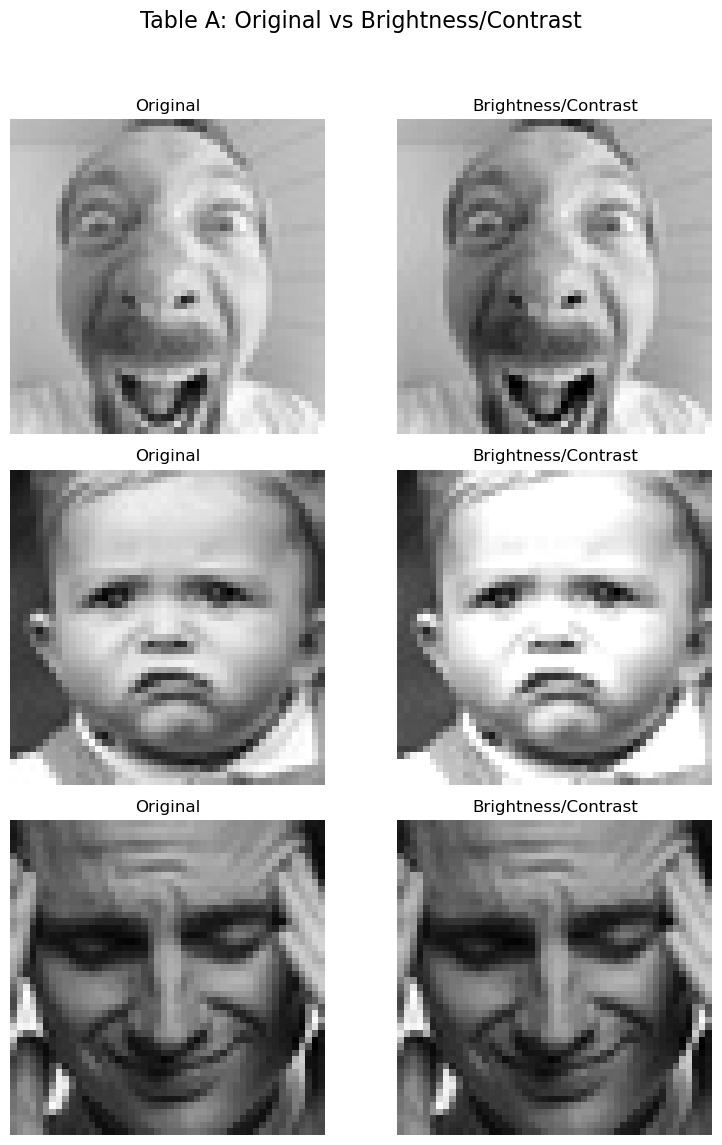

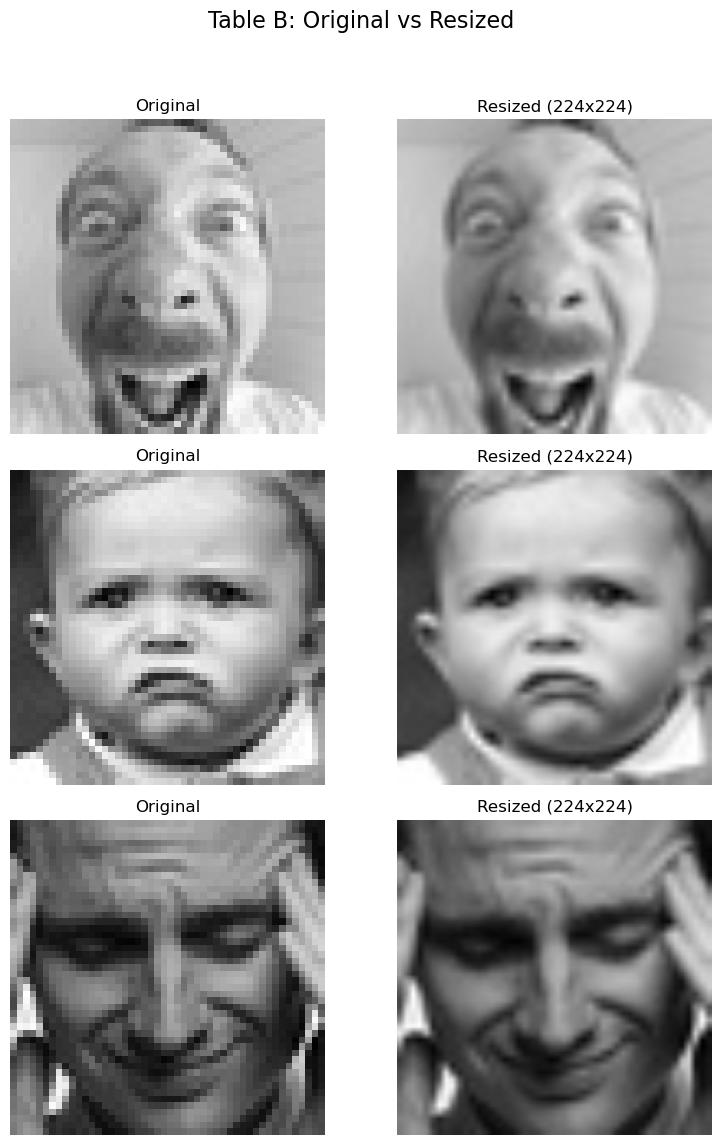

In [3]:
# Create two separate tables: (A) Original vs Brightness/Contrast, (B) Original vs Resized
import matplotlib.pyplot as plt

sample_indices = [0, 1, 2]

# Table A: Original vs Brightness/Contrast
fig_a, axes_a = plt.subplots(3, 2, figsize=(8, 12))
for i, idx in enumerate(sample_indices):
    img_path = train_dataset.img_paths[idx]
    orig_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    bc_img = train_dataset.random_brightness_contrast(orig_img.copy())
    axes_a[i, 0].imshow(orig_img, cmap='gray')
    axes_a[i, 0].set_title('Original')
    axes_a[i, 0].axis('off')
    axes_a[i, 1].imshow(bc_img, cmap='gray')
    axes_a[i, 1].set_title('Brightness/Contrast')
    axes_a[i, 1].axis('off')
fig_a.suptitle('Table A: Original vs Brightness/Contrast', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Table B: Original vs Resized
fig_b, axes_b = plt.subplots(3, 2, figsize=(8, 12))
for i, idx in enumerate(sample_indices):
    img_path = train_dataset.img_paths[idx]
    orig_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(orig_img, (train_dataset.img_size, train_dataset.img_size))
    axes_b[i, 0].imshow(orig_img, cmap='gray')
    axes_b[i, 0].set_title('Original')
    axes_b[i, 0].axis('off')
    axes_b[i, 1].imshow(resized_img, cmap='gray')
    axes_b[i, 1].set_title(f'Resized ({train_dataset.img_size}x{train_dataset.img_size})')
    axes_b[i, 1].axis('off')
fig_b.suptitle('Table B: Original vs Resized', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()